<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/non_neural_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

     |████████████████████████████████| 276kB 9.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=bfa538842f0760027fbd7fac2124219f9e8043ae381b1c007d75d32aaa587a6a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.6MB 8.5MB/s 
Mounted at /gdrive


In [2]:
from functions import *
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the data

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
145767,tractatus logico-philosophicus,Wittgenstein,analytic,But that is the general propositional form.,But that is the general propositional form.,43,but that is the general propositional form.,but that be the general propositional form .,"['But', 'that', 'is', 'the', 'general', 'propo..."
178492,philosophical troubles,Kripke,analytic,the experimenter is so very sloppy.,the experimenter is so very sloppy.,35,the experimenter is so very sloppy.,the experimenter be so very sloppy .,"['the', 'experimenter', 'is', 'so', 'very', 's..."
117908,search after truth,Malebranche,rationalism,"Before finishing this chapter, three things mu...","Before finishing this chapter, three things mu...",58,"before finishing this chapter, three things mu...","before finish this chapter , three thing must...","['Before', 'finishing', 'this', 'chapter', ','..."
303472,essential works of lenin,Lenin,communism,"For example, they spread disquieting rumors ab...","For example, they spread disquieting rumors ab...",82,"for example, they spread disquieting rumors ab...","for example , -PRON- spread disquieting rumor...","['For', 'example', ',', 'they', 'spread', 'dis..."
220161,the phenomenology of perception,Merleau-Ponty,phenomenology,"well in hand', I can see what things are 'with...","well in hand', I can see what things are 'with...",84,"well in hand', i can see what things are 'with...","well in hand ' , -PRON- can see what thing be...","['well', 'in', 'hand', ""'"", ',', 'I', 'can', '..."


In [4]:
stopwords_list = stopwords.words('english') + list(string.punctuation) 
stopwords_list += ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 
                    'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 
                    'us', 'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 
                    'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 
                    'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 
                    'hyl', 'phil', 'one'] + stopwords_list

### Baseline NB Bayes Model

In [5]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [6]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [7]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

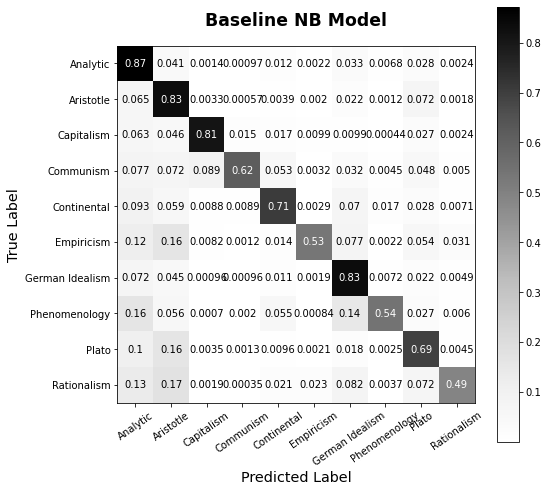

In [8]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [9]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.64      0.87      0.74     13360
      aristotle       0.63      0.83      0.72     12200
     capitalism       0.85      0.81      0.83      4559
      communism       0.93      0.62      0.74      4432
    continental       0.82      0.71      0.76      8319
     empiricism       0.90      0.53      0.67      5109
german_idealism       0.71      0.83      0.77     10466
  phenomenology       0.91      0.54      0.68      7177
          plato       0.69      0.69      0.69      9640
    rationalism       0.86      0.49      0.63      5722

       accuracy                           0.73     80984
      macro avg       0.80      0.69      0.72     80984
   weighted avg       0.76      0.73      0.72     80984



Accuracy in the low 70s over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [10]:
df['school'].value_counts(normalize=True)

analytic           0.165026
aristotle          0.150579
german_idealism    0.128291
plato              0.118514
continental        0.104280
phenomenology      0.088274
rationalism        0.070847
empiricism         0.062698
capitalism         0.056085
communism          0.055406
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [12]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [13]:
# to use the sampler, the data must be numerical
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# # get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

#### Oversampling

In [14]:
ros = RandomOverSampler(sampling_strategy='all')

In [15]:
x_under, y_under = ros.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

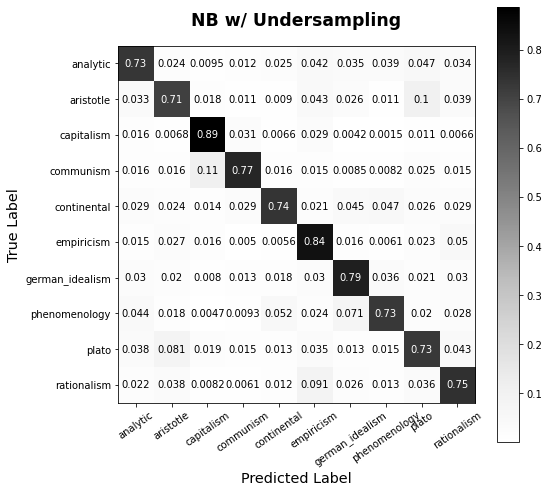

In [17]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [18]:
print(classification_report(y_test, nb_undersampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13326
           1       0.80      0.71      0.75     12177
           2       0.75      0.89      0.81      4571
           3       0.76      0.77      0.76      4377
           4       0.82      0.74      0.78      8346
           5       0.60      0.84      0.70      5045
           6       0.80      0.79      0.80     10563
           7       0.75      0.73      0.74      7077
           8       0.71      0.73      0.72      9745
           9       0.64      0.75      0.69      5757

    accuracy                           0.75     80984
   macro avg       0.75      0.77      0.75     80984
weighted avg       0.76      0.75      0.76     80984



Not bad, we got a 2% or so increase in accuracy. Let's check if oversampling helps any more.

#### Undersampling

In [19]:
rus = RandomUnderSampler(sampling_strategy='all')

In [20]:
x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
nb_oversampled = MultinomialNB()
nb_oversampled.fit(x_under, y_under)
nb_oversampled_preds = nb_oversampled.predict(tf_idf_data_test)

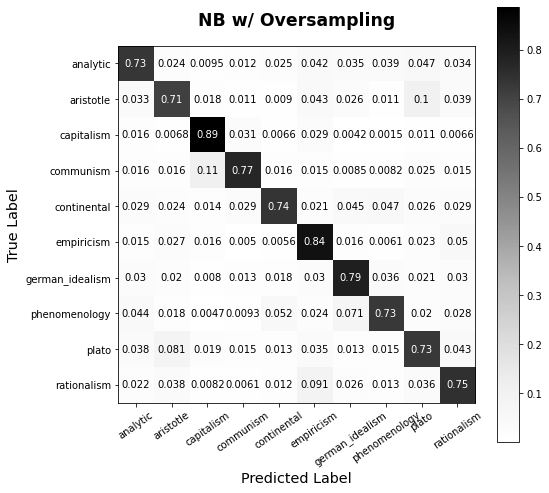

In [22]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Oversampling', label_dict=flipped_dict)

In [23]:
print(classification_report(y_test, nb_oversampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13326
           1       0.80      0.71      0.75     12177
           2       0.75      0.89      0.81      4571
           3       0.76      0.77      0.76      4377
           4       0.82      0.74      0.78      8346
           5       0.60      0.84      0.70      5045
           6       0.80      0.79      0.80     10563
           7       0.75      0.73      0.74      7077
           8       0.71      0.73      0.72      9745
           9       0.64      0.75      0.69      5757

    accuracy                           0.75     80984
   macro avg       0.75      0.77      0.75     80984
weighted avg       0.76      0.75      0.76     80984



Unsurprisingly, not much of a different result. It seems like Multinomial Naive Bayes can give us about 75% accuracy. 

It's perhaps worth checking if lemmatization can help the model.

### NB with Lemmatization

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [25]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [26]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


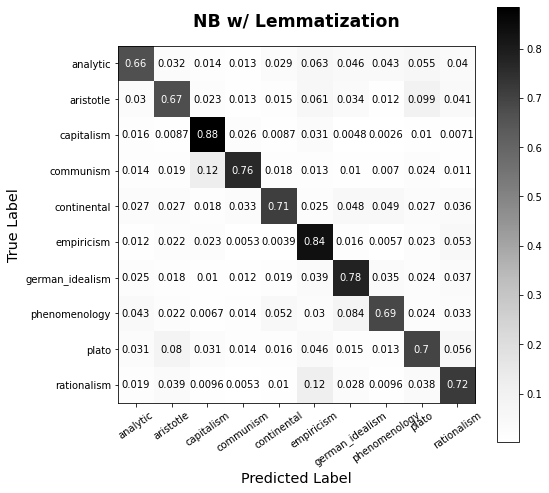

In [27]:
nb_lemma = MultinomialNB()
nb_lemma.fit(x_over_lemma, y_over_lemma)
nb_lemma_preds = nb_lemma.predict(tf_idf_data_test)

plot_pretty_cf(nb_lemma, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [28]:
print(classification_report(y_test, nb_lemma_preds))

              precision    recall  f1-score   support

           0       0.83      0.66      0.74     13227
           1       0.79      0.67      0.73     12239
           2       0.69      0.88      0.78      4622
           3       0.75      0.76      0.76      4553
           4       0.80      0.71      0.75      8493
           5       0.53      0.84      0.65      5081
           6       0.77      0.78      0.77     10395
           7       0.74      0.69      0.71      7028
           8       0.68      0.70      0.69      9538
           9       0.60      0.72      0.65      5808

    accuracy                           0.72     80984
   macro avg       0.72      0.74      0.72     80984
weighted avg       0.74      0.72      0.73     80984



Not great, and worse than non-lemmatized versions. This makes sense since lemmatization essentially masks information that might have had some small part to play in the classification math.

### NB with Bigrams

While singular words may not always be indicative of a school, certain phrases are often almost entirely exclusive to a school. So it stands to reason that incorporating bigrams into our data would help the model.

In [29]:
# vectorize, this time adjusting the ngram range to include bigrams
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=custom_stopwords, 
                                 ngram_range=(1,2))
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [30]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [31]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


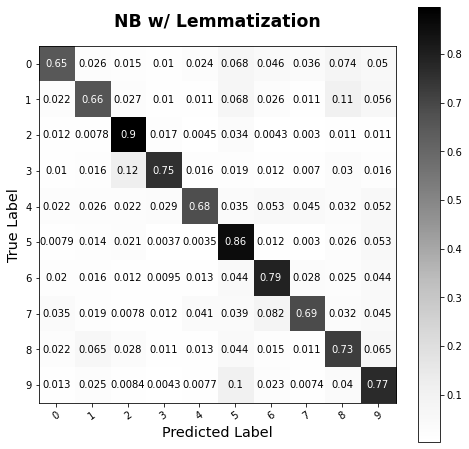

In [32]:
nb_bigrams = MultinomialNB()
nb_bigrams.fit(x_over_lemma, y_over_lemma)
nb_bigrams_preds = nb_bigrams.predict(tf_idf_data_test)

plot_pretty_cf(nb_bigrams, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [33]:
print(classification_report(y_test, nb_bigrams_preds))

              precision    recall  f1-score   support

           0       0.87      0.65      0.74     13227
           1       0.82      0.66      0.73     12239
           2       0.69      0.90      0.78      4622
           3       0.79      0.75      0.77      4553
           4       0.83      0.68      0.75      8493
           5       0.52      0.86      0.65      5081
           6       0.78      0.79      0.78     10395
           7       0.76      0.69      0.72      7028
           8       0.66      0.73      0.69      9538
           9       0.56      0.77      0.65      5808

    accuracy                           0.73     80984
   macro avg       0.73      0.75      0.73     80984
weighted avg       0.75      0.73      0.73     80984



### Random Forest Classifier

Random Forests don't always do well on this kind of task, but it's perhaps worth trying. We'll just do an untuned model to see if it gets any kind of results worth exploring. 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(unify_list, df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [ ]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


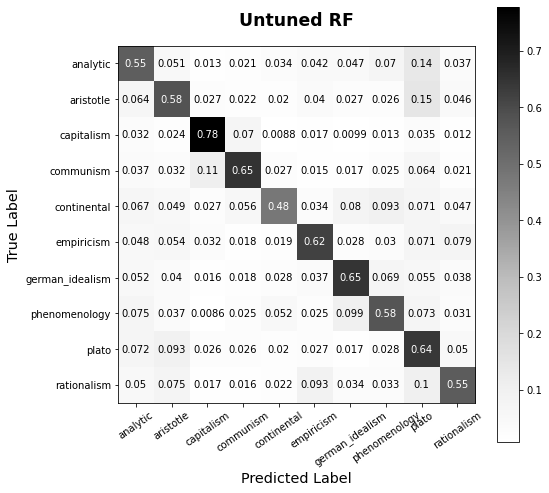

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_over, y_over)
rf_preds = rf.predict(tf_idf_data_test)

plot_pretty_cf(rf, tf_idf_data_test, y_test, 
               title='Untuned RF', label_dict=flipped_dict)

In [ ]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.65      0.55      0.59     13321
           1       0.66      0.58      0.62     12280
           2       0.64      0.78      0.70      4544
           3       0.57      0.65      0.61      4433
           4       0.68      0.48      0.56      8551
           5       0.52      0.62      0.57      4957
           6       0.69      0.65      0.67     10323
           7       0.54      0.58      0.56      7218
           8       0.48      0.64      0.55      9765
           9       0.50      0.55      0.53      5693

    accuracy                           0.59     81085
   macro avg       0.59      0.61      0.60     81085
weighted avg       0.61      0.59      0.60     81085

